In [1]:
import random

import matplotlib.pyplot as plt
import torch
from PIL import Image
from transformers import CLIPSegForImageSegmentation, CLIPSegProcessor

import amazon_dataset

In [260]:
DATASET = 'Clothing_Shoes_and_Jewelry'
#DATASET = 'Musical_Instruments'
#DATASET = 'Home_and_Kitchen'

In [140]:
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

In [261]:
reviews = amazon_dataset.reviews_df(DATASET)
reviews.sample(n=3)

,id,asin,reviewerID,reviewerName,overall,text,reviewTime,summary,verified,vote
155570,28226899,B00NE72G4E,A2D2VA4G603TLL,Ray,5.0,I absolutely LOVE it!!! Wonderful addition to ...,2018-07-08,You will get addicted to this watch.,True,NaN
11424,1776806,B0001YRE04,A2VQEVKNEORUW3,Kellyk1023,2.0,These are the smallest 42x30s I've ever attemp...,2018-03-20,Run very small!!!,True,NaN
173939,31692098,B01DDHE1BK,A1LFYNLKPZVRVZ,Lrsmit10,5.0,Nice dress. Just as described.,2018-07-26,Five Stars,True,NaN


In [262]:
products = amazon_dataset.products_df(DATASET)
products.sample(n=3)

,asin,description,title,brand,main_cat,rank,price,image_slug,image_url,feature,category,tech_detail
id,,,,,,,,,,,,
2680485,B01HGD2P0Q,"Dickies, Dickys or Dickeys - No matter how you...",kilofly 3pc Women's Faux Turtleneck Half Top M...,kilofly,None,"26,550inClothing,ShoesJewelry(",$13.49,[41tSVr3Q7CL],[https://m.media-amazon.com/images/I/41tSVr3Q7...,"[Cotton fabric, Great Value - Includes 3 turtl...","[Clothing, Shoes & Jewelry, Novelty & More, Cl...",None
1418239,B00LBWA45C,A chic brown leather cross-body bag that infus...,14 Inches Rugged- Chic Distressed Leather Wome...,Syon,Sports & Outdoors,"128,140inSportsOutdoors(",$31.99,[51ayqyPjsYL],[https://m.media-amazon.com/images/I/51ayqyPjs...,"[Made of 100% genuine natural leather, Adjusta...","[Clothing, Shoes & Jewelry, Women, Handbags & ...",None
560156,B007XD4QRU,"Featuring ruched detail, puff sleeves, and a p...",Allegra K Women's Single Breasted Long Sleeves...,Allegra K,None,"435,854inClothing,ShoesJewelry(",$15.99 - $17.99,[41715tJtSLL],[https://m.media-amazon.com/images/I/41715tJtS...,"[100% Polyester, Point Collar, Ruched, Career ...","[Clothing, Shoes & Jewelry, Women, Clothing, T...",None


In [ ]:
466765

Int64Index([2452184], dtype='int64', name='id')
adidas Originals Women's Linear Leggings


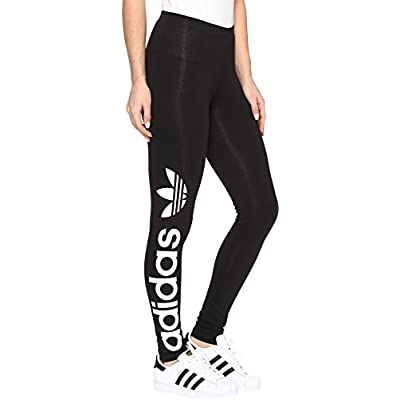

In [396]:
some_product = products.loc[
    ~products['title'].isna() & products['image_slug'].apply(lambda x: len(x) > 0)
].sample(n=1)
print(some_product.index)
some_product = some_product.iloc[0]
some_image_slug = random.choice(some_product['image_slug'])

image_dir = amazon_dataset.product_images_dir(DATASET)
product_image = Image.open(image_dir / f'{some_image_slug}.jpg')

print(some_product['title'])
product_image

In [400]:
prompts = some_product['title'].split(' ') + [ some_product['title'] ]
prompts

['adidas',
 'Originals',
 "Women's",
 'Linear',
 'Leggings',
 "adidas Originals Women's Linear Leggings"]

In [408]:
prompts = \
['adidas',
 "Women's",
 "Leggings"]

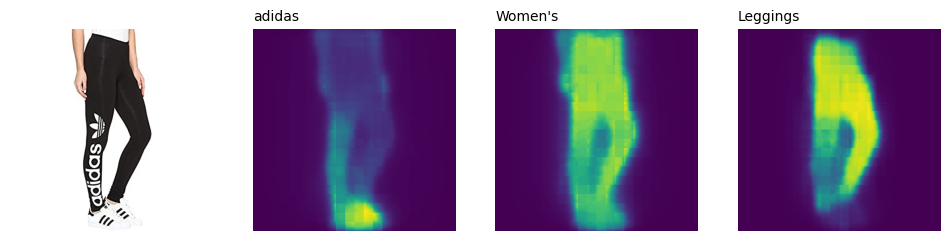

In [409]:
inputs = processor(text=prompts, images=[product_image] * len(prompts), padding="max_length", return_tensors="pt")
# predict
with torch.no_grad():
  outputs = model(**inputs)
preds = outputs.logits.unsqueeze(1)

_, ax = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))

[a.axis('off') for a in ax.flatten()]

ax[0].imshow(product_image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompt) for i, prompt in enumerate(prompts)];